In [1]:
import pandas as pd
import sys
import datetime
import matplotlib.pylab as plt
import numpy as np
from math import log, floor, ceil
from typing import Dict

In [2]:
START_DATE = datetime.date(2020,2,24)

In [3]:
def create_filename(day_str: str) -> str:
    return ('../dati-province/dpc-covid19-ita-province-' + day_str + '.csv')

In [4]:
def handle_Toscana_20200326_error(cases: Dict[str, int]) -> Dict[str, int]:
    cases['20200327'] = cases['20200326'] + floor((cases['20200328'] - cases['20200326'])/2)
    cases['20200328'] = cases['20200327'] + ceil((cases['20200328'] - cases['20200326'])/2)
    return cases

In [5]:
def calculate_and_create_chart_for_province(start_date: datetime.date, province: str):
    day = start_date
    cases: Dict[str,int] = {}
    while day<=datetime.date.today():
        day_str: str = day.strftime("%Y%m%d")
        filename: str = create_filename(day_str)
        df: pd.DataFrame = pd.read_csv(filename, encoding = "ISO-8859-1")
        cases[day_str] = int(df[df["denominazione_provincia"]==province]["totale_casi"])
        day: datetime.date = day + datetime.timedelta(days = 1)
    
    if df[df["denominazione_provincia"]==province]["denominazione_regione"].any()=='Toscana':
        cases = handle_Toscana_20200326_error(cases)
    
    cases_df: pd.DataFrame = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    cases_df_today = cases_df[cases_df["Day"]==datetime.date.today().strftime("%Y%m%d")]["Cases"].sum()
    print("Total cases per 1000 inhabitants up to today:", round(calculate_cases_to_inhabitants_ratio(cases_df_today, province),4))
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()
    plt.yscale("log")
    plt.show()
    return

In [6]:

def calculate_and_create_chart_for_region(start_date: datetime.date, region: str):
    day: datetime.date = start_date
    cases: Dict[str, int] = {}
    while day<=datetime.date.today():
        day_str: str = day.strftime("%Y%m%d")
        filename: str = create_filename(day_str)
        df: pd.DataFrame = pd.read_csv(filename, encoding = "ISO-8859-1")
        cases[day_str] = int(df[(df["denominazione_regione"]==region)&(df["denominazione_provincia"]!='In fase di definizione/aggiornamento')]["totale_casi"].sum())
        day: datetime.date = day + datetime.timedelta(days = 1)
        
    if region == 'Toscana':
        cases = handle_Toscana_20200326_error(cases)

    cases_df = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()
    plt.yscale("log")
    plt.show()
    return

In [7]:
def calculate_and_create_chart_for_Italy(start_date: datetime.date):
    day = start_date
    cases = {}
    while day<=datetime.date.today():
        day_str: str = day.strftime("%Y%m%d")
        filename: str = create_filename(day_str)
        df: pd.DataFrame = pd.read_csv(filename, encoding = "ISO-8859-1")
        cases[day_str] = int(df[df["denominazione_provincia"]!='In fase di definizione/aggiornamento']["totale_casi"].sum())
        day: datetime.date = day + datetime.timedelta(days = 1)

    cases_df: pd.DataFrame = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()
    plt.yscale("log")
    plt.show()
    return

In [8]:
def calculate_stats(cases_df):
    cases_df_today = cases_df[cases_df["Day"]==datetime.date.today().strftime("%Y%m%d")]["Cases"].sum()
    cases_df_yesterday = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 1)).strftime("%Y%m%d")]["Cases"].sum()
    cases_df_five_days_ago = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 5)).strftime("%Y%m%d")]["Cases"].sum()
    cases_df_six_days_ago = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 6)).strftime("%Y%m%d")]["Cases"].sum()
    print("Total cases up to today:", cases_df_today)
    print("New cases registered today:", cases_df_today-cases_df_yesterday)
    if int(cases_df_yesterday) != 0:
        print("New cases registered today in %:", round((cases_df_today-cases_df_yesterday)/cases_df_yesterday*100,2))

    print("Doubling time in the last five days:", round(calculate_doubling_time_in_the_last_five_days(cases_df_today, cases_df_five_days_ago), 1))
    print("Doubling time yesterday:", round(calculate_doubling_time_in_the_last_five_days(cases_df_yesterday, cases_df_six_days_ago), 1))
    print("Trend of new cases (in %) in the last 5 days:", round((cases_df_today-cases_df_five_days_ago)/cases_df_five_days_ago*100,2))
    
    return

In [9]:
def calculate_doubling_time_in_the_last_five_days(cases_df_today, cases_df_five_days_ago):
    if cases_df_five_days_ago ==0:
        return np.nan
    log_result = log(cases_df_today/cases_df_five_days_ago)
    if log_result != 0:
        return (5*log(2))/(log_result)
    else:
        return np.nan
    

In [10]:
def calculate_cases_to_inhabitants_ratio(cases: int, province: str) -> float:
    df_province: pd.DataFrame = pd.read_csv("../general/province.csv")
    inhabitants = df_province[df_province["Provincia"]==province]["Residenti"].str.replace('.', '', regex=True).sum()
    return int(cases)/int(inhabitants)*1000

# Casi di COVID-19 in Italia - COVID-19 cases in Italy

Total cases up to today: 141218
New cases registered today: 4136
New cases registered today in %: 3.02
Doubling time in the last five days: 22.0
Doubling time yesterday: 20.8
Trend of new cases (in %) in the last 5 days: 17.09


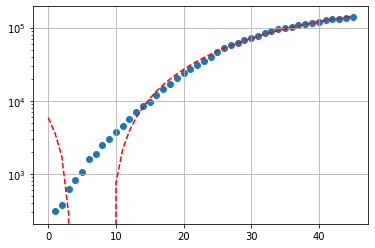

In [11]:
calculate_and_create_chart_for_Italy(START_DATE)

# Casi di COVID-19 in Abruzzo - COVID-19 cases in Abruzzo

Total cases up to today: 1931
New cases registered today: 72
New cases registered today in %: 3.87
Doubling time in the last five days: 20.3
Doubling time yesterday: 20.0
Trend of new cases (in %) in the last 5 days: 18.61


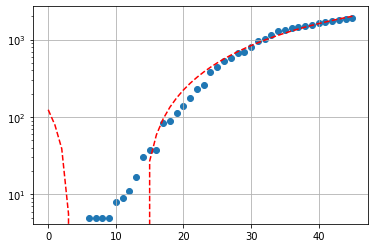

In [12]:
calculate_and_create_chart_for_region(START_DATE, 'Abruzzo')

## Chieti

Total cases per 1000 inhabitants up to today: 0.9482
Total cases up to today: 369
New cases registered today: 8
New cases registered today in %: 2.22
Doubling time in the last five days: 22.8
Doubling time yesterday: 22.8
Trend of new cases (in %) in the last 5 days: 16.4


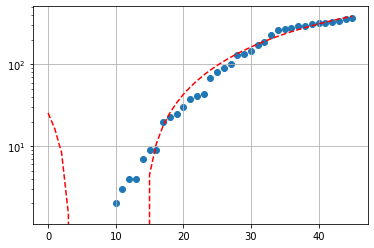

In [13]:
calculate_and_create_chart_for_province(START_DATE, 'Chieti')

## L'Aquila

Total cases per 1000 inhabitants up to today: 0.6591
Total cases up to today: 199
New cases registered today: 2
New cases registered today in %: 1.02
Doubling time in the last five days: 25.8
Doubling time yesterday: 20.2
Trend of new cases (in %) in the last 5 days: 14.37


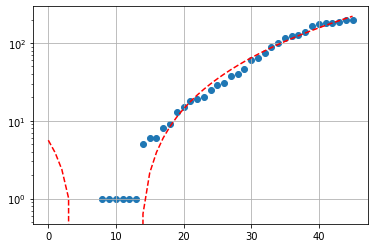

In [14]:
calculate_and_create_chart_for_province(START_DATE, "L'Aquila")

## Pescara

Total cases per 1000 inhabitants up to today: 2.5054
Total cases up to today: 805
New cases registered today: 34
New cases registered today in %: 4.41
Doubling time in the last five days: 24.8
Doubling time yesterday: 24.4
Trend of new cases (in %) in the last 5 days: 15.0


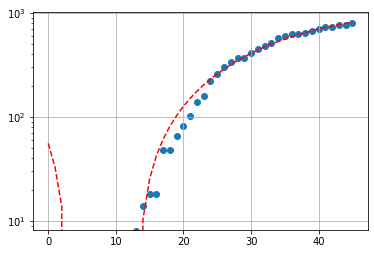

In [15]:
calculate_and_create_chart_for_province(START_DATE, 'Pescara')

## Teramo

Total cases per 1000 inhabitants up to today: 1.8008
Total cases up to today: 558
New cases registered today: 28
New cases registered today in %: 5.28
Doubling time in the last five days: 14.2
Doubling time yesterday: 14.6
Trend of new cases (in %) in the last 5 days: 27.69


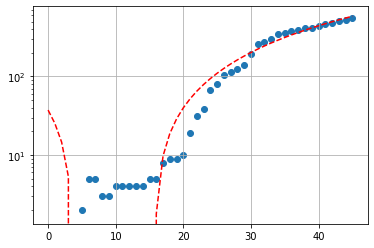

In [16]:
calculate_and_create_chart_for_province(START_DATE, 'Teramo')

# Casi di COVID-19 in Basilicata - COVID-19 cases in Basilicata

Total cases up to today: 303
New cases registered today: 6
New cases registered today in %: 2.02
Doubling time in the last five days: 25.2
Doubling time yesterday: 26.8
Trend of new cases (in %) in the last 5 days: 14.77


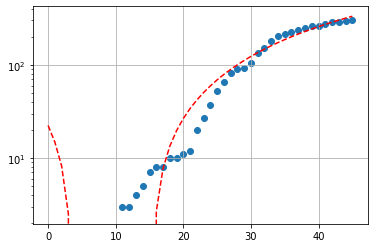

In [17]:
calculate_and_create_chart_for_region(START_DATE, 'Basilicata')

## Matera

Total cases per 1000 inhabitants up to today: 0.7312
Total cases up to today: 146
New cases registered today: 1
New cases registered today in %: 0.69
Doubling time in the last five days: 22.3
Doubling time yesterday: 22.2
Trend of new cases (in %) in the last 5 days: 16.8


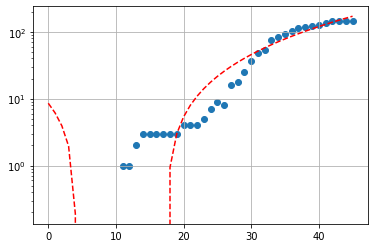

In [18]:
calculate_and_create_chart_for_province(START_DATE, 'Matera')

## Potenza

Total cases per 1000 inhabitants up to today: 0.4235
Total cases up to today: 157
New cases registered today: 5
New cases registered today in %: 3.29
Doubling time in the last five days: 28.5
Doubling time yesterday: 33.4
Trend of new cases (in %) in the last 5 days: 12.95


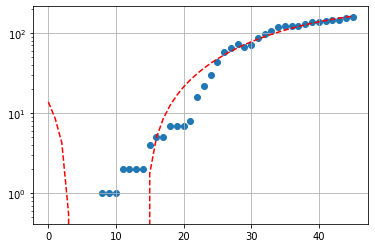

In [19]:
calculate_and_create_chart_for_province(START_DATE, 'Potenza')

# Casi di COVID-19 nella Provincia Autonoma di Bolzano - COVID-19 cases in Autonomous Province of Bolzano

Total cases up to today: 1903
New cases registered today: 68
New cases registered today in %: 3.71
Doubling time in the last five days: 19.4
Doubling time yesterday: 21.3
Trend of new cases (in %) in the last 5 days: 19.54


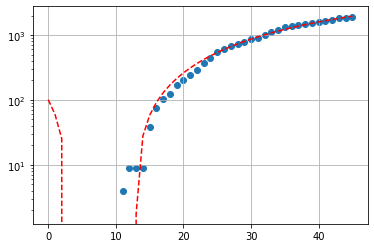

In [20]:
calculate_and_create_chart_for_region(START_DATE, 'P.A. Bolzano')

# Casi di COVID-19 in Calabria - COVID-19 cases in Calabria

Total cases up to today: 872
New cases registered today: 15
New cases registered today in %: 1.75
Doubling time in the last five days: 20.9
Doubling time yesterday: 21.8
Trend of new cases (in %) in the last 5 days: 18.0


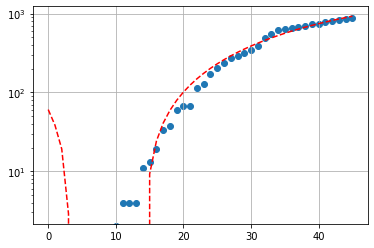

In [21]:
calculate_and_create_chart_for_region(START_DATE, 'Calabria')

## Catanzaro

Total cases per 1000 inhabitants up to today: 0.4774
Total cases up to today: 173
New cases registered today: 4
New cases registered today in %: 2.37
Doubling time in the last five days: 24.3
Doubling time yesterday: 29.1
Trend of new cases (in %) in the last 5 days: 15.33


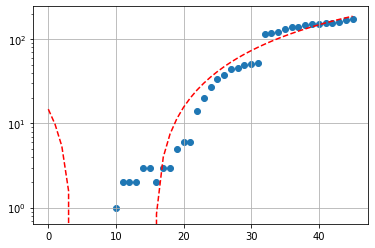

In [22]:
calculate_and_create_chart_for_province(START_DATE, 'Catanzaro')

## Cosenza

Total cases per 1000 inhabitants up to today: 0.3864
Total cases up to today: 275
New cases registered today: 9
New cases registered today in %: 3.38
Doubling time in the last five days: 11.6
Doubling time yesterday: 12.8
Trend of new cases (in %) in the last 5 days: 34.8


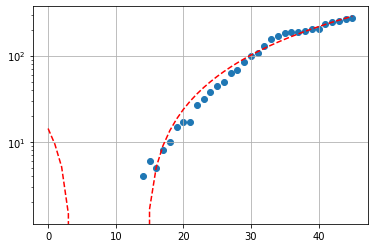

In [23]:
calculate_and_create_chart_for_province(START_DATE, 'Cosenza')

## Crotone

Total cases per 1000 inhabitants up to today: 0.6436
Total cases up to today: 113
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 54.2
Doubling time yesterday: 54.2
Trend of new cases (in %) in the last 5 days: 6.6


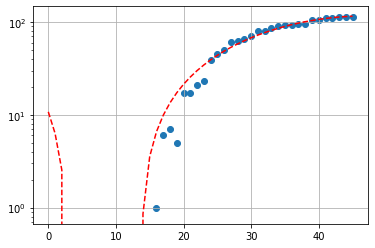

In [24]:
calculate_and_create_chart_for_province(START_DATE, 'Crotone')

## Reggio di Calabria

Total cases per 1000 inhabitants up to today: 0.4514
Total cases up to today: 250
New cases registered today: 2
New cases registered today in %: 0.81
Doubling time in the last five days: 29.2
Doubling time yesterday: 26.9
Trend of new cases (in %) in the last 5 days: 12.61


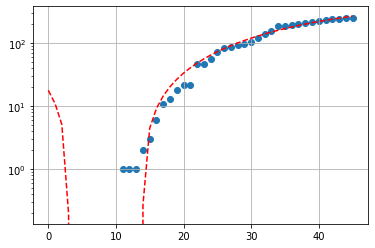

In [25]:
calculate_and_create_chart_for_province(START_DATE, 'Reggio di Calabria')

## Vibo Valentia

Total cases per 1000 inhabitants up to today: 0.3774
Total cases up to today: 61
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 51.1
Doubling time yesterday: 28.4
Trend of new cases (in %) in the last 5 days: 7.02


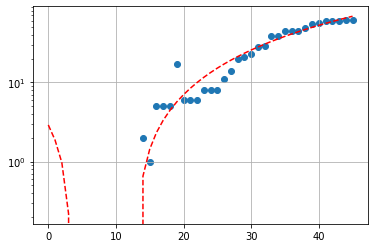

In [26]:
calculate_and_create_chart_for_province(START_DATE, 'Vibo Valentia')

# Casi di COVID-19 in Campania - COVID-19 cases in Campania

Total cases up to today: 3074
New cases registered today: 57
New cases registered today in %: 1.89
Doubling time in the last five days: 22.8
Doubling time yesterday: 19.1
Trend of new cases (in %) in the last 5 days: 16.44


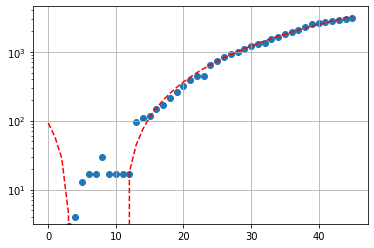

In [27]:
calculate_and_create_chart_for_region(START_DATE, 'Campania')

## Avellino

Total cases per 1000 inhabitants up to today: 0.8949
Total cases up to today: 379
New cases registered today: 1
New cases registered today in %: 0.26
Doubling time in the last five days: 45.2
Doubling time yesterday: 32.7
Trend of new cases (in %) in the last 5 days: 7.98


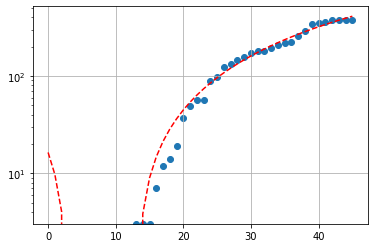

In [28]:
calculate_and_create_chart_for_province(START_DATE, 'Avellino')

## Benevento

Total cases per 1000 inhabitants up to today: 0.5185
Total cases up to today: 145
New cases registered today: 12
New cases registered today in %: 9.02
Doubling time in the last five days: 6.6
Doubling time yesterday: 7.7
Trend of new cases (in %) in the last 5 days: 68.6


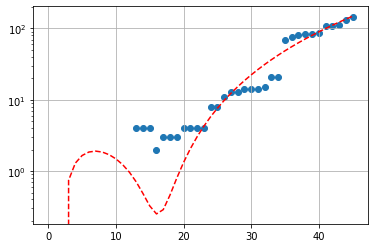

In [29]:
calculate_and_create_chart_for_province(START_DATE, 'Benevento')

## Caserta

Total cases per 1000 inhabitants up to today: 0.3809
Total cases up to today: 352
New cases registered today: 3
New cases registered today in %: 0.86
Doubling time in the last five days: 14.9
Doubling time yesterday: 12.4
Trend of new cases (in %) in the last 5 days: 26.16


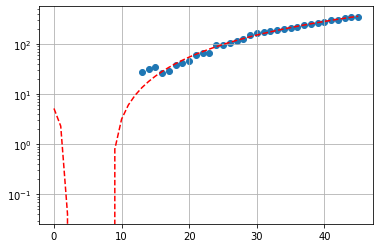

In [30]:
calculate_and_create_chart_for_province(START_DATE, 'Caserta')

## Napoli

Total cases per 1000 inhabitants up to today: 0.5468
Total cases up to today: 1699
New cases registered today: 31
New cases registered today in %: 1.86
Doubling time in the last five days: 27.5
Doubling time yesterday: 22.3
Trend of new cases (in %) in the last 5 days: 13.42


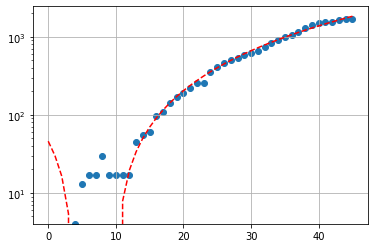

In [31]:
calculate_and_create_chart_for_province(START_DATE, 'Napoli')

## Salerno

Total cases per 1000 inhabitants up to today: 0.4517
Total cases up to today: 499
New cases registered today: 10
New cases registered today in %: 2.04
Doubling time in the last five days: 21.9
Doubling time yesterday: 17.3
Trend of new cases (in %) in the last 5 days: 17.14


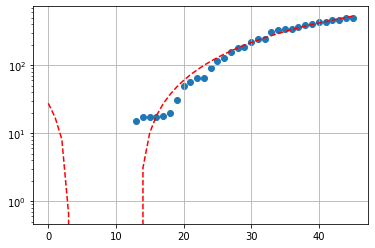

In [32]:
calculate_and_create_chart_for_province(START_DATE, 'Salerno')

# Casi di COVID-19 in Emilia Romagna - COVID-19 cases in Emilia Romagna

Total cases up to today: 0
New cases registered today: 0
Doubling time in the last five days: nan
Doubling time yesterday: nan
Trend of new cases (in %) in the last 5 days: nan


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


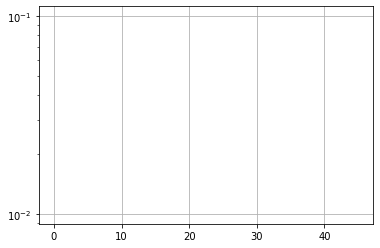

In [33]:
calculate_and_create_chart_for_region(START_DATE, 'Emilia Romagna')

## Bologna

Total cases per 1000 inhabitants up to today: 2.8299
Total cases up to today: 2856
New cases registered today: 98
New cases registered today in %: 3.55
Doubling time in the last five days: 21.4
Doubling time yesterday: 21.0
Trend of new cases (in %) in the last 5 days: 17.58


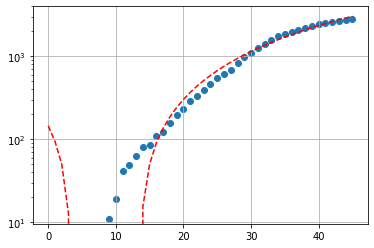

In [34]:
calculate_and_create_chart_for_province(START_DATE, 'Bologna')

## Ferrara

Total cases per 1000 inhabitants up to today: 1.6161
Total cases up to today: 563
New cases registered today: 25
New cases registered today in %: 4.65
Doubling time in the last five days: 20.1
Doubling time yesterday: 9.1
Trend of new cases (in %) in the last 5 days: 18.78


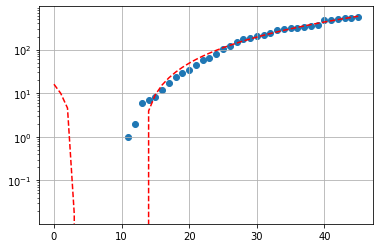

In [35]:
calculate_and_create_chart_for_province(START_DATE, 'Ferrara')

## Modena

Total cases per 1000 inhabitants up to today: 4.0907
Total cases up to today: 2867
New cases registered today: 56
New cases registered today in %: 1.99
Doubling time in the last five days: 29.7
Doubling time yesterday: 29.4
Trend of new cases (in %) in the last 5 days: 12.39


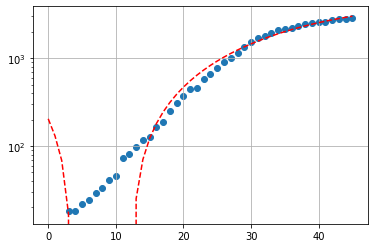

In [36]:
calculate_and_create_chart_for_province(START_DATE, 'Modena')

## Parma

Total cases per 1000 inhabitants up to today: 5.3932
Total cases up to today: 2421
New cases registered today: 26
New cases registered today in %: 1.09
Doubling time in the last five days: 36.4
Doubling time yesterday: 24.8
Trend of new cases (in %) in the last 5 days: 10.0


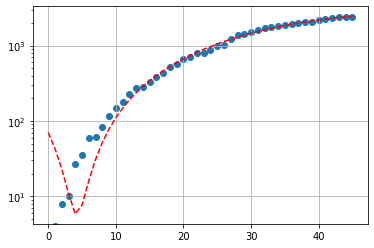

In [37]:
calculate_and_create_chart_for_province(START_DATE, 'Parma')

## Piacenza

Total cases per 1000 inhabitants up to today: 10.5315
Total cases up to today: 3020
New cases registered today: 40
New cases registered today in %: 1.34
Doubling time in the last five days: 57.1
Doubling time yesterday: 59.4
Trend of new cases (in %) in the last 5 days: 6.26


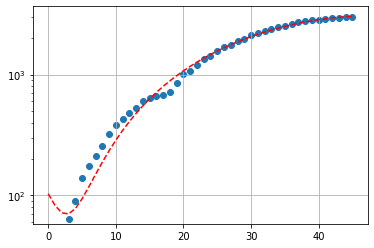

In [38]:
calculate_and_create_chart_for_province(START_DATE, 'Piacenza')

## Ravenna

Total cases per 1000 inhabitants up to today: 1.9187
Total cases up to today: 751
New cases registered today: 5
New cases registered today in %: 0.67
Doubling time in the last five days: 39.6
Doubling time yesterday: 27.0
Trend of new cases (in %) in the last 5 days: 9.16


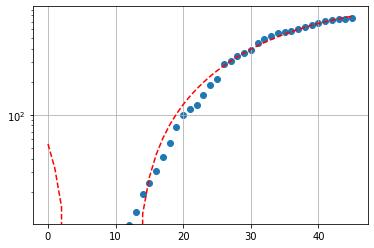

In [39]:
calculate_and_create_chart_for_province(START_DATE, 'Ravenna')

## Reggio nell'Emilia

Total cases per 1000 inhabitants up to today: 6.5824
Total cases up to today: 3505
New cases registered today: 153
New cases registered today in %: 4.56
Doubling time in the last five days: 18.6
Doubling time yesterday: 19.3
Trend of new cases (in %) in the last 5 days: 20.53


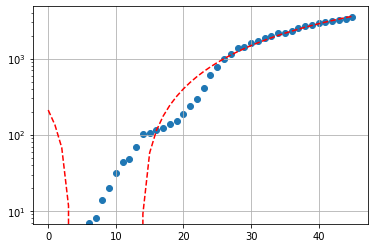

In [40]:
calculate_and_create_chart_for_province(START_DATE, "Reggio nell'Emilia")

## Rimini

Total cases per 1000 inhabitants up to today: 4.7894
Total cases up to today: 1613
New cases registered today: 17
New cases registered today in %: 1.07
Doubling time in the last five days: 60.4
Doubling time yesterday: 63.3
Trend of new cases (in %) in the last 5 days: 5.91


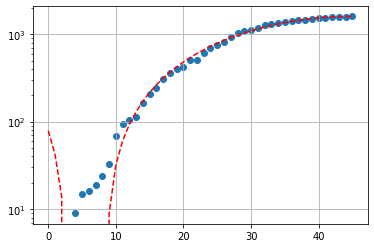

In [41]:
calculate_and_create_chart_for_province(START_DATE, 'Rimini')

# Casi di COVID-19 in Friuli Venezia Giulia - COVID-19 cases in Friuli Venezia Giulia

Total cases up to today: 2293
New cases registered today: 82
New cases registered today in %: 3.71
Doubling time in the last five days: 23.7
Doubling time yesterday: 20.9
Trend of new cases (in %) in the last 5 days: 15.75


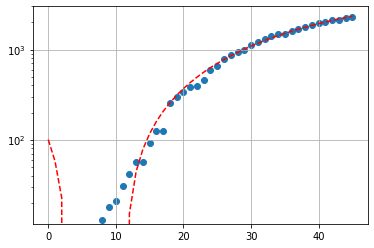

In [42]:
calculate_and_create_chart_for_region(START_DATE, 'Friuli Venezia Giulia')

## Gorizia

Total cases per 1000 inhabitants up to today: 0.8591
Total cases up to today: 120
New cases registered today: -1
New cases registered today in %: -0.83
Doubling time in the last five days: 81.4
Doubling time yesterday: 40.2
Trend of new cases (in %) in the last 5 days: 4.35


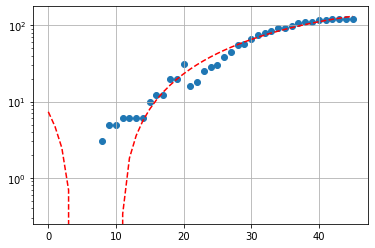

In [43]:
calculate_and_create_chart_for_province(START_DATE, 'Gorizia')

## Pordenone

Total cases per 1000 inhabitants up to today: 1.644
Total cases up to today: 513
New cases registered today: 16
New cases registered today in %: 3.22
Doubling time in the last five days: 32.4
Doubling time yesterday: 36.5
Trend of new cases (in %) in the last 5 days: 11.28


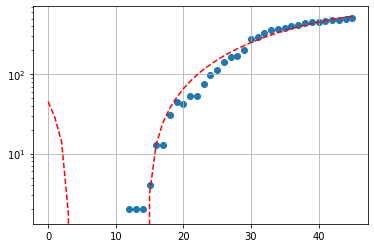

In [44]:
calculate_and_create_chart_for_province(START_DATE, 'Pordenone')

## Trieste

Total cases per 1000 inhabitants up to today: 3.4984
Total cases up to today: 821
New cases registered today: 58
New cases registered today in %: 7.6
Doubling time in the last five days: 14.9
Doubling time yesterday: 17.9
Trend of new cases (in %) in the last 5 days: 26.11


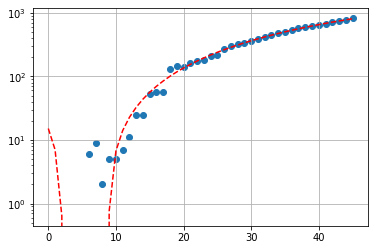

In [45]:
calculate_and_create_chart_for_province(START_DATE, 'Trieste')

## Udine

Total cases per 1000 inhabitants up to today: 1.5787
Total cases up to today: 839
New cases registered today: 9
New cases registered today in %: 1.08
Doubling time in the last five days: 32.4
Doubling time yesterday: 17.5
Trend of new cases (in %) in the last 5 days: 11.27


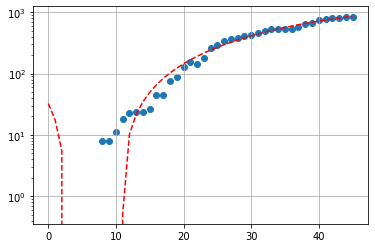

In [46]:
calculate_and_create_chart_for_province(START_DATE, 'Udine')

# Casi di COVID-19 nel Lazio - COVID-19 cases in Lazio

Total cases up to today: 4391
New cases registered today: 160
New cases registered today in %: 3.78
Doubling time in the last five days: 21.2
Doubling time yesterday: 20.6
Trend of new cases (in %) in the last 5 days: 17.72


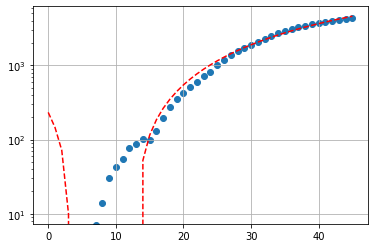

In [47]:
calculate_and_create_chart_for_region(START_DATE, 'Lazio')

## Frosinone

Total cases per 1000 inhabitants up to today: 0.8944
Total cases up to today: 441
New cases registered today: 16
New cases registered today in %: 3.76
Doubling time in the last five days: 18.1
Doubling time yesterday: 19.0
Trend of new cases (in %) in the last 5 days: 21.15


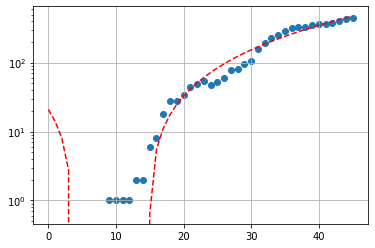

In [48]:
calculate_and_create_chart_for_province(START_DATE, 'Frosinone')

## Latina

Total cases per 1000 inhabitants up to today: 0.6558
Total cases up to today: 377
New cases registered today: 13
New cases registered today in %: 3.57
Doubling time in the last five days: 20.4
Doubling time yesterday: 19.2
Trend of new cases (in %) in the last 5 days: 18.55


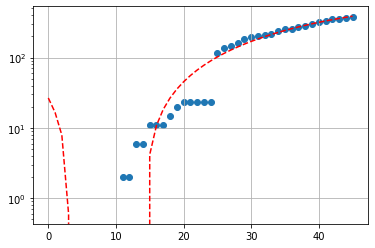

In [49]:
calculate_and_create_chart_for_province(START_DATE, 'Latina')

## Rieti

Total cases per 1000 inhabitants up to today: 1.7088
Total cases up to today: 269
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 9.7
Doubling time yesterday: 9.7
Trend of new cases (in %) in the last 5 days: 43.09


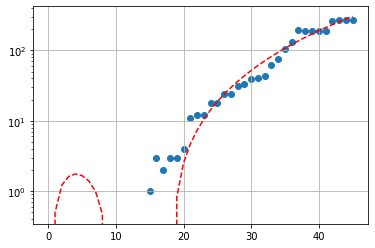

In [50]:
calculate_and_create_chart_for_province(START_DATE, 'Rieti')

## Roma

Total cases per 1000 inhabitants up to today: 0.695
Total cases up to today: 3026
New cases registered today: 116
New cases registered today in %: 3.99
Doubling time in the last five days: 24.1
Doubling time yesterday: 23.0
Trend of new cases (in %) in the last 5 days: 15.5


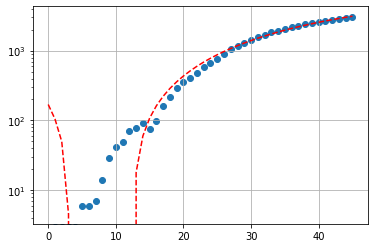

In [51]:
calculate_and_create_chart_for_province(START_DATE, 'Roma')

## Viterbo

Total cases per 1000 inhabitants up to today: 0.8715
Total cases up to today: 278
New cases registered today: 15
New cases registered today in %: 5.7
Doubling time in the last five days: 23.6
Doubling time yesterday: 22.9
Trend of new cases (in %) in the last 5 days: 15.83


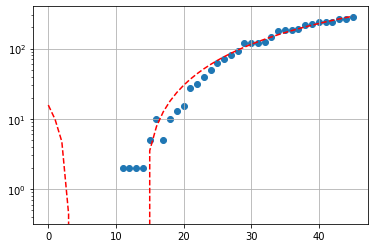

In [52]:
calculate_and_create_chart_for_province(START_DATE, 'Viterbo')

# Casi di COVID-19 in Liguria - COVID-19 cases in Liguria

Total cases up to today: 4955
New cases registered today: 112
New cases registered today in %: 2.31
Doubling time in the last five days: 4.1
Doubling time yesterday: 3.9
Trend of new cases (in %) in the last 5 days: 131.76


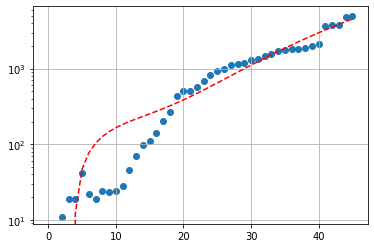

In [53]:
calculate_and_create_chart_for_region(START_DATE, 'Liguria')

## Genova

Total cases per 1000 inhabitants up to today: 3.3515
Total cases up to today: 2849
New cases registered today: 64
New cases registered today in %: 2.3
Doubling time in the last five days: 4.5
Doubling time yesterday: 4.0
Trend of new cases (in %) in the last 5 days: 117.15


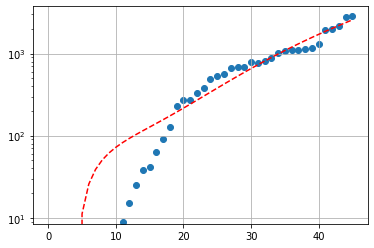

In [54]:
calculate_and_create_chart_for_province(START_DATE, 'Genova')

## Imperia

Total cases per 1000 inhabitants up to today: 3.8628
Total cases up to today: 831
New cases registered today: 32
New cases registered today in %: 4.01
Doubling time in the last five days: 2.6
Doubling time yesterday: 2.7
Trend of new cases (in %) in the last 5 days: 270.98


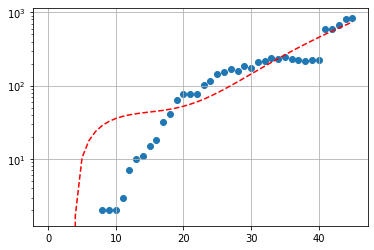

In [55]:
calculate_and_create_chart_for_province(START_DATE, 'Imperia')

## La Spezia

Total cases per 1000 inhabitants up to today: 2.8047
Total cases up to today: 619
New cases registered today: 14
New cases registered today in %: 2.31
Doubling time in the last five days: 5.8
Doubling time yesterday: 5.5
Trend of new cases (in %) in the last 5 days: 81.52


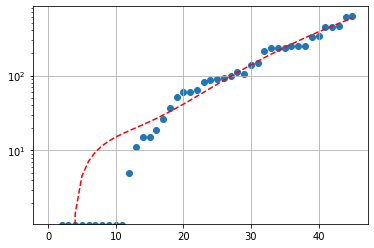

In [56]:
calculate_and_create_chart_for_province(START_DATE, 'La Spezia')

## Savona

Total cases per 1000 inhabitants up to today: 2.3478
Total cases up to today: 656
New cases registered today: 2
New cases registered today in %: 0.31
Doubling time in the last five days: 3.8
Doubling time yesterday: 3.8
Trend of new cases (in %) in the last 5 days: 151.34


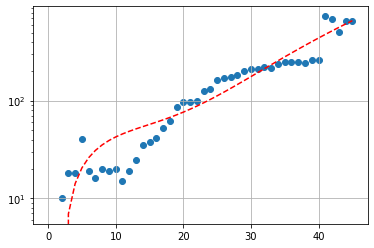

In [57]:
calculate_and_create_chart_for_province(START_DATE, 'Savona')

# Casi di COVID-19 in Lombardia - COVID-19 cases in Lombardy

Total cases up to today: 53585
New cases registered today: 1353
New cases registered today in %: 2.59
Doubling time in the last five days: 31.8
Doubling time yesterday: 29.8
Trend of new cases (in %) in the last 5 days: 11.51


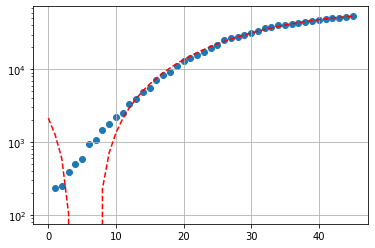

In [58]:
calculate_and_create_chart_for_region(START_DATE, 'Lombardia')

## Bergamo

Total cases per 1000 inhabitants up to today: 9.0483
Total cases up to today: 10043
New cases registered today: 112
New cases registered today in %: 1.13
Doubling time in the last five days: 74.8
Doubling time yesterday: 54.1
Trend of new cases (in %) in the last 5 days: 4.75


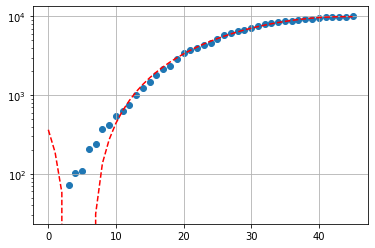

In [59]:
calculate_and_create_chart_for_province(START_DATE, 'Bergamo')

## Brescia

Total cases per 1000 inhabitants up to today: 8.0186
Total cases up to today: 10122
New cases registered today: 213
New cases registered today in %: 2.15
Doubling time in the last five days: 35.5
Doubling time yesterday: 36.6
Trend of new cases (in %) in the last 5 days: 10.26


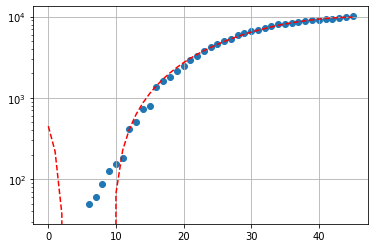

In [60]:
calculate_and_create_chart_for_province(START_DATE, 'Brescia')

## Como

Total cases per 1000 inhabitants up to today: 2.6742
Total cases up to today: 1605
New cases registered today: 63
New cases registered today in %: 4.09
Doubling time in the last five days: 17.7
Doubling time yesterday: 16.9
Trend of new cases (in %) in the last 5 days: 21.68


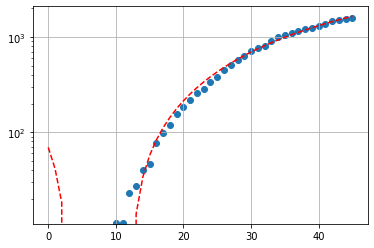

In [61]:
calculate_and_create_chart_for_province(START_DATE, 'Como')

## Cremona

Total cases per 1000 inhabitants up to today: 12.4907
Total cases up to today: 4489
New cases registered today: 67
New cases registered today in %: 1.52
Doubling time in the last five days: 44.7
Doubling time yesterday: 45.4
Trend of new cases (in %) in the last 5 days: 8.06


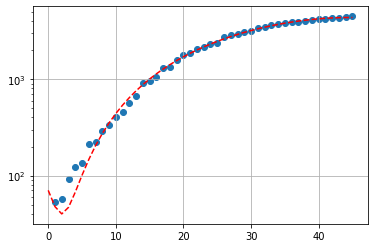

In [62]:
calculate_and_create_chart_for_province(START_DATE, 'Cremona')

## Lecco

Total cases per 1000 inhabitants up to today: 5.3207
Total cases up to today: 1805
New cases registered today: 50
New cases registered today in %: 2.85
Doubling time in the last five days: 33.6
Doubling time yesterday: 36.0
Trend of new cases (in %) in the last 5 days: 10.87


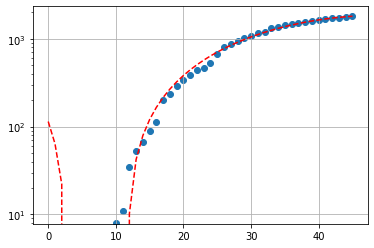

In [63]:
calculate_and_create_chart_for_province(START_DATE, 'Lecco')

## Lodi

Total cases per 1000 inhabitants up to today: 10.3603
Total cases up to today: 2376
New cases registered today: 29
New cases registered today in %: 1.24
Doubling time in the last five days: 57.9
Doubling time yesterday: 59.4
Trend of new cases (in %) in the last 5 days: 6.17


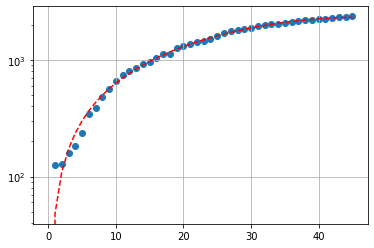

In [64]:
calculate_and_create_chart_for_province(START_DATE, 'Lodi')

## Mantova

Total cases per 1000 inhabitants up to today: 5.5185
Total cases up to today: 2277
New cases registered today: 61
New cases registered today in %: 2.75
Doubling time in the last five days: 24.9
Doubling time yesterday: 21.4
Trend of new cases (in %) in the last 5 days: 14.94


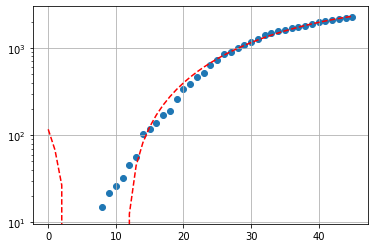

In [65]:
calculate_and_create_chart_for_province(START_DATE, 'Mantova')

## Milano

Total cases per 1000 inhabitants up to today: 3.8776
Total cases up to today: 12479
New cases registered today: 440
New cases registered today in %: 3.65
Doubling time in the last five days: 24.3
Doubling time yesterday: 23.5
Trend of new cases (in %) in the last 5 days: 15.34


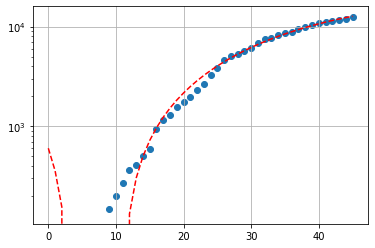

In [66]:
calculate_and_create_chart_for_province(START_DATE, 'Milano')

## Monza e della Brianza

Total cases per 1000 inhabitants up to today: 3.8614
Total cases up to today: 3355
New cases registered today: 91
New cases registered today in %: 2.79
Doubling time in the last five days: 25.9
Doubling time yesterday: 21.3
Trend of new cases (in %) in the last 5 days: 14.31


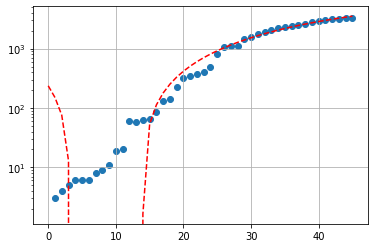

In [67]:
calculate_and_create_chart_for_province(START_DATE, 'Monza e della Brianza')

## Pavia

Total cases per 1000 inhabitants up to today: 5.2791
Total cases up to today: 2889
New cases registered today: 66
New cases registered today in %: 2.34
Doubling time in the last five days: 23.9
Doubling time yesterday: 18.1
Trend of new cases (in %) in the last 5 days: 15.61


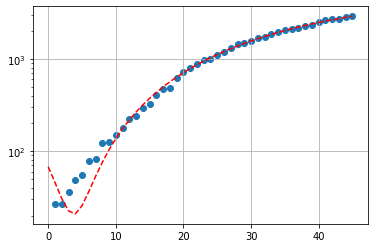

In [68]:
calculate_and_create_chart_for_province(START_DATE, 'Pavia')

## Sondrio

Total cases per 1000 inhabitants up to today: 3.6046
Total cases up to today: 654
New cases registered today: 18
New cases registered today in %: 2.83
Doubling time in the last five days: 23.1
Doubling time yesterday: 20.5
Trend of new cases (in %) in the last 5 days: 16.16


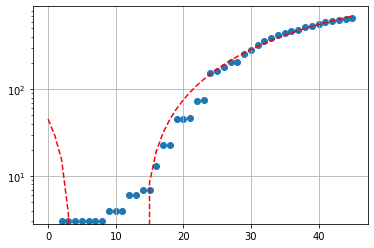

In [69]:
calculate_and_create_chart_for_province(START_DATE, 'Sondrio')

## Varese

Total cases per 1000 inhabitants up to today: 1.6752
Total cases up to today: 1491
New cases registered today: 143
New cases registered today in %: 10.61
Doubling time in the last five days: 13.3
Doubling time yesterday: 16.0
Trend of new cases (in %) in the last 5 days: 29.88


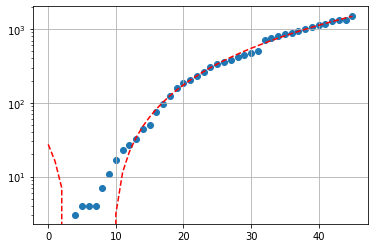

In [70]:
calculate_and_create_chart_for_province(START_DATE, 'Varese')

# Casi di COVID-19 nelle Marche - COVID-19 cases in Marche

Total cases up to today: 4832
New cases registered today: 92
New cases registered today in %: 1.94
Doubling time in the last five days: 26.8
Doubling time yesterday: 25.6
Trend of new cases (in %) in the last 5 days: 13.8


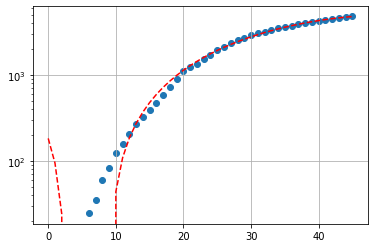

In [71]:
calculate_and_create_chart_for_region(START_DATE, 'Marche')

## Ancona

Total cases per 1000 inhabitants up to today: 3.1237
Total cases up to today: 1481
New cases registered today: 26
New cases registered today in %: 1.79
Doubling time in the last five days: 25.1
Doubling time yesterday: 24.5
Trend of new cases (in %) in the last 5 days: 14.81


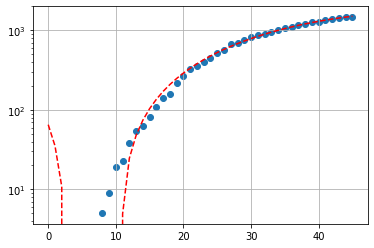

In [72]:
calculate_and_create_chart_for_province(START_DATE, 'Ancona')

## Ascoli Piceno

Total cases per 1000 inhabitants up to today: 1.1268
Total cases up to today: 236
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 270.9
Doubling time yesterday: 202.7
Trend of new cases (in %) in the last 5 days: 1.29


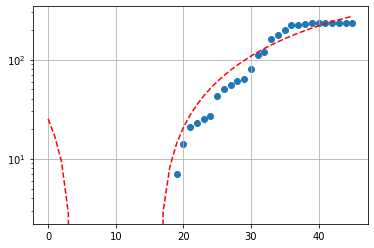

In [73]:
calculate_and_create_chart_for_province(START_DATE, 'Ascoli Piceno')

## Fermo

Total cases per 1000 inhabitants up to today: 1.9388
Total cases up to today: 339
New cases registered today: 5
New cases registered today in %: 1.5
Doubling time in the last five days: 32.8
Doubling time yesterday: 30.4
Trend of new cases (in %) in the last 5 days: 11.15


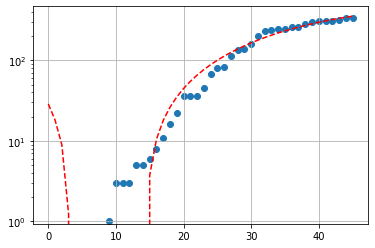

In [74]:
calculate_and_create_chart_for_province(START_DATE, 'Fermo')

## Macerata

Total cases per 1000 inhabitants up to today: 2.2952
Total cases up to today: 732
New cases registered today: 18
New cases registered today in %: 2.52
Doubling time in the last five days: 17.1
Doubling time yesterday: 14.4
Trend of new cases (in %) in the last 5 days: 22.41


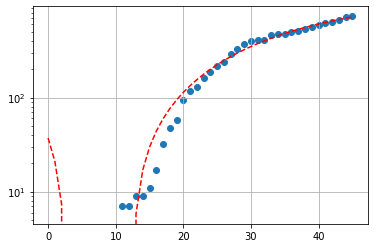

In [75]:
calculate_and_create_chart_for_province(START_DATE, 'Macerata')

## Pesaro e Urbino

Total cases per 1000 inhabitants up to today: 5.6666
Total cases up to today: 2044
New cases registered today: 43
New cases registered today in %: 2.15
Doubling time in the last five days: 29.9
Doubling time yesterday: 30.5
Trend of new cases (in %) in the last 5 days: 12.31


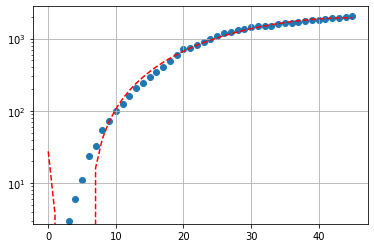

In [76]:
calculate_and_create_chart_for_province(START_DATE, 'Pesaro e Urbino')

# Casi di COVID-19 in Molise - COVID-19 cases in Molise¶

Total cases up to today: 219
New cases registered today: 10
New cases registered today in %: 4.78
Doubling time in the last five days: 28.6
Doubling time yesterday: 14.3
Trend of new cases (in %) in the last 5 days: 12.89


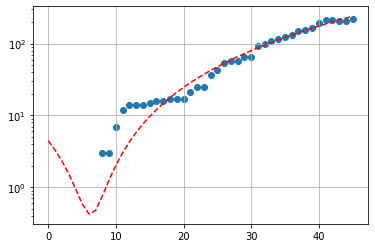

In [77]:
calculate_and_create_chart_for_region(START_DATE, 'Molise')

## Campobasso

Total cases per 1000 inhabitants up to today: 0.7835
Total cases up to today: 176
New cases registered today: 10
New cases registered today in %: 6.02
Doubling time in the last five days: 26.0
Doubling time yesterday: 32.1
Trend of new cases (in %) in the last 5 days: 14.29


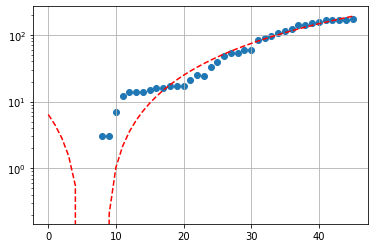

In [78]:
calculate_and_create_chart_for_province(START_DATE, 'Campobasso')

## Isernia

Total cases per 1000 inhabitants up to today: 0.5011
Total cases up to today: 43
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 47.9
Doubling time yesterday: 3.3
Trend of new cases (in %) in the last 5 days: 7.5


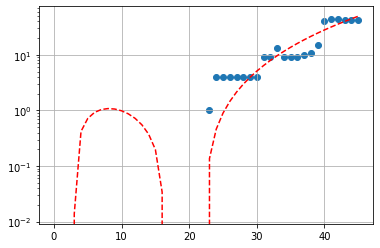

In [79]:
calculate_and_create_chart_for_province(START_DATE, 'Isernia')

# Casi di COVID-19 in Piemonte - COVID-19 cases in Piedmont 

Total cases up to today: 14268
New cases registered today: 644
New cases registered today in %: 4.73
Doubling time in the last five days: 16.1
Doubling time yesterday: 14.4
Trend of new cases (in %) in the last 5 days: 24.08


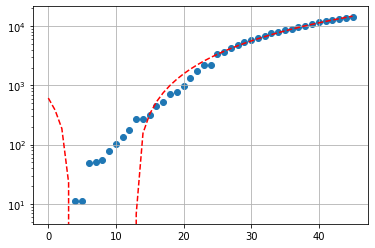

In [80]:
calculate_and_create_chart_for_region(START_DATE, 'Piemonte')

## Alessandria

Total cases per 1000 inhabitants up to today: 4.8774
Total cases up to today: 2081
New cases registered today: 65
New cases registered today in %: 3.22
Doubling time in the last five days: 12.9
Doubling time yesterday: 11.5
Trend of new cases (in %) in the last 5 days: 30.8


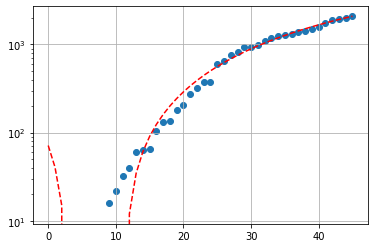

In [81]:
calculate_and_create_chart_for_province(START_DATE, 'Alessandria')

## Asti

Total cases per 1000 inhabitants up to today: 3.0229
Total cases up to today: 655
New cases registered today: 12
New cases registered today in %: 1.87
Doubling time in the last five days: 22.1
Doubling time yesterday: 16.8
Trend of new cases (in %) in the last 5 days: 16.96


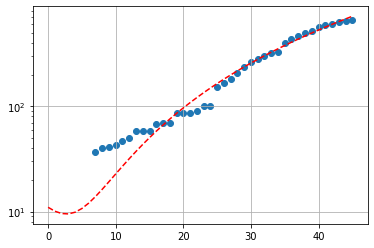

In [82]:
calculate_and_create_chart_for_province(START_DATE, 'Asti')

## Biella

Total cases per 1000 inhabitants up to today: 3.478
Total cases up to today: 621
New cases registered today: 21
New cases registered today in %: 3.5
Doubling time in the last five days: 33.0
Doubling time yesterday: 34.1
Trend of new cases (in %) in the last 5 days: 11.09


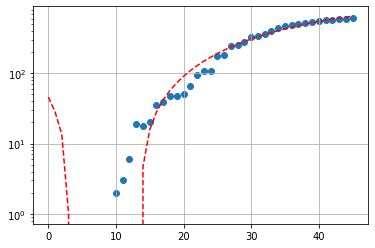

In [83]:
calculate_and_create_chart_for_province(START_DATE, 'Biella')

## Cuneo

Total cases per 1000 inhabitants up to today: 2.2084
Total cases up to today: 1301
New cases registered today: 74
New cases registered today in %: 6.03
Doubling time in the last five days: 10.4
Doubling time yesterday: 9.4
Trend of new cases (in %) in the last 5 days: 39.59


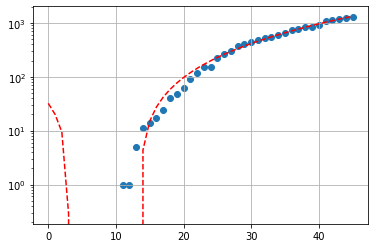

In [84]:
calculate_and_create_chart_for_province(START_DATE, 'Cuneo')

## Novara

Total cases per 1000 inhabitants up to today: 3.2906
Total cases up to today: 1218
New cases registered today: 72
New cases registered today in %: 6.28
Doubling time in the last five days: 15.0
Doubling time yesterday: 16.6
Trend of new cases (in %) in the last 5 days: 25.96


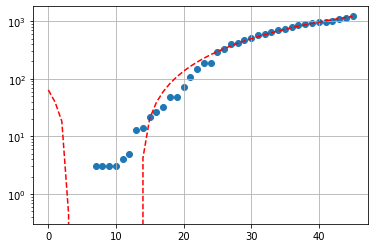

In [85]:
calculate_and_create_chart_for_province(START_DATE, 'Novara')

## Torino

Total cases per 1000 inhabitants up to today: 3.0401
Total cases up to today: 6925
New cases registered today: 330
New cases registered today in %: 5.0
Doubling time in the last five days: 19.0
Doubling time yesterday: 15.8
Trend of new cases (in %) in the last 5 days: 19.98


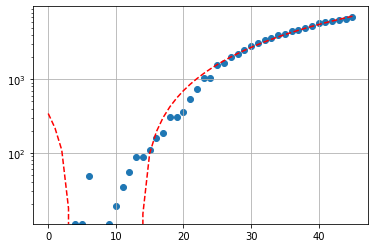

In [86]:
calculate_and_create_chart_for_province(START_DATE, 'Torino')

## 	Verbano-Cusio-Ossola

Total cases per 1000 inhabitants up to today: 4.8477
Total cases up to today: 774
New cases registered today: 55
New cases registered today in %: 7.65
Doubling time in the last five days: 9.4
Doubling time yesterday: 9.8
Trend of new cases (in %) in the last 5 days: 44.67


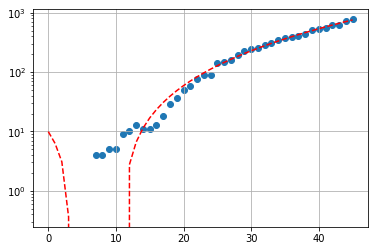

In [87]:
calculate_and_create_chart_for_province(START_DATE, 'Verbano-Cusio-Ossola')

## Vercelli

Total cases per 1000 inhabitants up to today: 3.9858
Total cases up to today: 693
New cases registered today: 15
New cases registered today in %: 2.21
Doubling time in the last five days: 20.1
Doubling time yesterday: 19.0
Trend of new cases (in %) in the last 5 days: 18.87


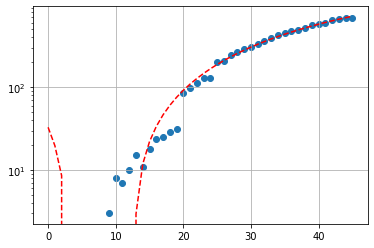

In [88]:
calculate_and_create_chart_for_province(START_DATE, 'Vercelli')

# Casi di COVID-19 in Puglia - COVID-19 cases in Apulia

Total cases up to today: 2683
New cases registered today: 84
New cases registered today in %: 3.23
Doubling time in the last five days: 18.0
Doubling time yesterday: 18.4
Trend of new cases (in %) in the last 5 days: 21.24


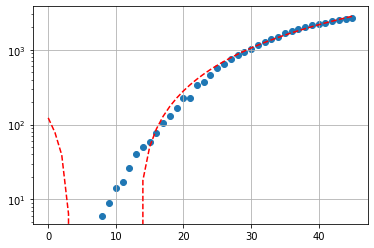

In [89]:
calculate_and_create_chart_for_region(START_DATE, 'Puglia')

## Bari

Total cases per 1000 inhabitants up to today: 0.6904
Total cases up to today: 870
New cases registered today: 9
New cases registered today in %: 1.05
Doubling time in the last five days: 26.1
Doubling time yesterday: 23.1
Trend of new cases (in %) in the last 5 days: 14.17


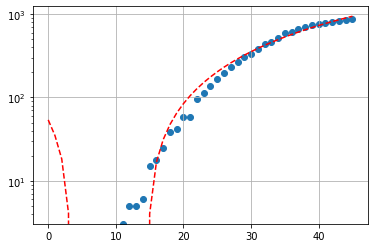

In [90]:
calculate_and_create_chart_for_province(START_DATE, 'Bari')

## 	Barletta-Andria-Trani

Total cases per 1000 inhabitants up to today: 0.5401
Total cases up to today: 212
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 7.0
Doubling time yesterday: 7.0
Trend of new cases (in %) in the last 5 days: 64.34


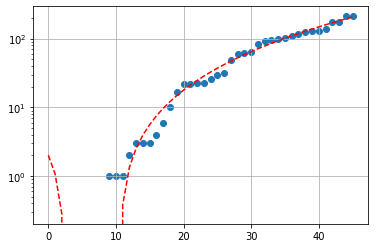

In [91]:
calculate_and_create_chart_for_province(START_DATE, 'Barletta-Andria-Trani')

## Brindisi

Total cases per 1000 inhabitants up to today: 0.753
Total cases up to today: 299
New cases registered today: 15
New cases registered today in %: 5.28
Doubling time in the last five days: 14.1
Doubling time yesterday: 13.1
Trend of new cases (in %) in the last 5 days: 27.78


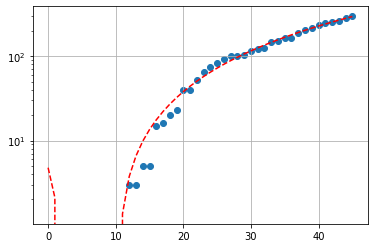

In [92]:
calculate_and_create_chart_for_province(START_DATE, 'Brindisi')

## Foggia

Total cases per 1000 inhabitants up to today: 1.1153
Total cases up to today: 701
New cases registered today: 49
New cases registered today in %: 7.52
Doubling time in the last five days: 13.9
Doubling time yesterday: 16.3
Trend of new cases (in %) in the last 5 days: 28.39


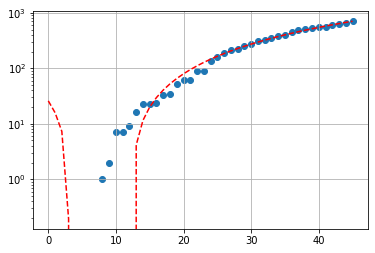

In [93]:
calculate_and_create_chart_for_province(START_DATE, 'Foggia')

## Lecce

Total cases per 1000 inhabitants up to today: 0.4925
Total cases up to today: 395
New cases registered today: 6
New cases registered today in %: 1.54
Doubling time in the last five days: 39.7
Doubling time yesterday: 43.2
Trend of new cases (in %) in the last 5 days: 9.12


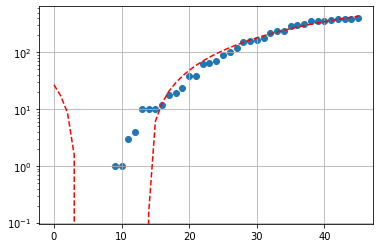

In [94]:
calculate_and_create_chart_for_province(START_DATE, 'Lecce')

## Taranto

Total cases per 1000 inhabitants up to today: 0.3531
Total cases up to today: 206
New cases registered today: 5
New cases registered today in %: 2.49
Doubling time in the last five days: 25.7
Doubling time yesterday: 28.5
Trend of new cases (in %) in the last 5 days: 14.44


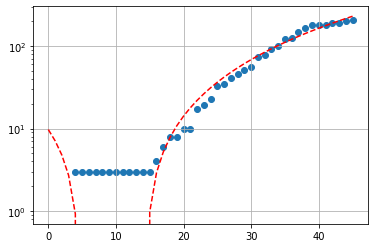

In [95]:
calculate_and_create_chart_for_province(START_DATE, 'Taranto')

# Casi di COVID-19 in Sardegna - COVID-19 cases in Sardinia

Total cases up to today: 1026
New cases registered today: 51
New cases registered today in %: 5.23
Doubling time in the last five days: 21.6
Doubling time yesterday: 20.7
Trend of new cases (in %) in the last 5 days: 17.39


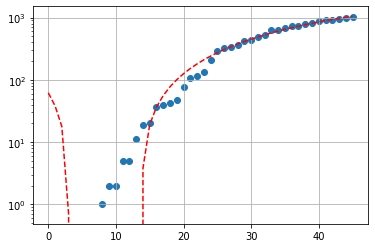

In [96]:
calculate_and_create_chart_for_region(START_DATE, 'Sardegna')

## Cagliari

Total cases per 1000 inhabitants up to today: 0.2873
Total cases up to today: 161
New cases registered today: 10
New cases registered today in %: 6.62
Doubling time in the last five days: 31.1
Doubling time yesterday: 29.0
Trend of new cases (in %) in the last 5 days: 11.81


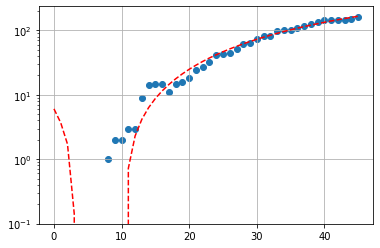

In [97]:
calculate_and_create_chart_for_province(START_DATE, 'Cagliari')

## Nuoro

Total cases per 1000 inhabitants up to today: 0.4292
Total cases up to today: 67
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 44.7
Doubling time yesterday: 44.7
Trend of new cases (in %) in the last 5 days: 8.06


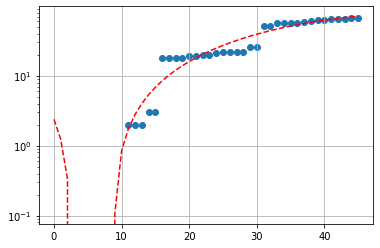

In [98]:
calculate_and_create_chart_for_province(START_DATE, 'Nuoro')

## Oristano

Total cases per 1000 inhabitants up to today: 0.1929
Total cases up to today: 31
New cases registered today: 2
New cases registered today in %: 6.9
Doubling time in the last five days: 7.9
Doubling time yesterday: 8.2
Trend of new cases (in %) in the last 5 days: 55.0


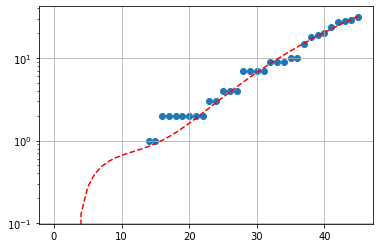

In [99]:
calculate_and_create_chart_for_province(START_DATE, 'Oristano')

## Sassari

Total cases per 1000 inhabitants up to today: 2.0683
Total cases up to today: 689
New cases registered today: 35
New cases registered today in %: 5.35
Doubling time in the last five days: 21.2
Doubling time yesterday: 19.4
Trend of new cases (in %) in the last 5 days: 17.78


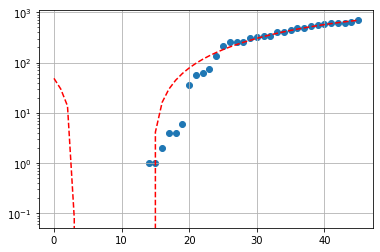

In [100]:
calculate_and_create_chart_for_province(START_DATE, 'Sassari')

# Casi di COVID-19 in Sicilia - COVID-19 cases in Sicily

Total cases up to today: 2232
New cases registered today: 73
New cases registered today in %: 3.38
Doubling time in the last five days: 24.0
Doubling time yesterday: 23.2
Trend of new cases (in %) in the last 5 days: 15.53


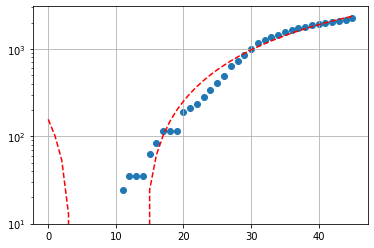

In [101]:
calculate_and_create_chart_for_region(START_DATE, 'Sicilia')

## Agrigento

Total cases per 1000 inhabitants up to today: 0.2602
Total cases up to today: 115
New cases registered today: 2
New cases registered today in %: 1.77
Doubling time in the last five days: 28.9
Doubling time yesterday: 28.4
Trend of new cases (in %) in the last 5 days: 12.75


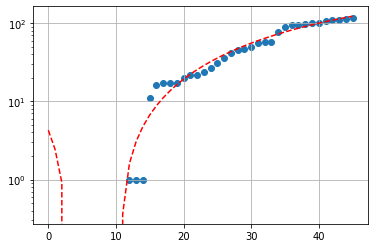

In [102]:
calculate_and_create_chart_for_province(START_DATE, 'Agrigento')

## Caltanissetta

Total cases per 1000 inhabitants up to today: 0.4153
Total cases up to today: 112
New cases registered today: 5
New cases registered today in %: 4.67
Doubling time in the last five days: 18.6
Doubling time yesterday: 13.6
Trend of new cases (in %) in the last 5 days: 20.43


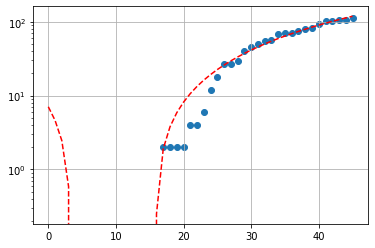

In [103]:
calculate_and_create_chart_for_province(START_DATE, 'Caltanissetta')

## Catania

Total cases per 1000 inhabitants up to today: 0.5946
Total cases up to today: 662
New cases registered today: 16
New cases registered today in %: 2.48
Doubling time in the last five days: 22.9
Doubling time yesterday: 24.0
Trend of new cases (in %) in the last 5 days: 16.34


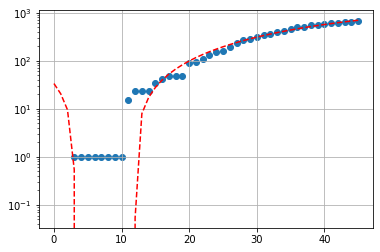

In [104]:
calculate_and_create_chart_for_province(START_DATE, 'Catania')

## Enna

Total cases per 1000 inhabitants up to today: 1.7852
Total cases up to today: 300
New cases registered today: 4
New cases registered today in %: 1.35
Doubling time in the last five days: 50.2
Doubling time yesterday: 24.5
Trend of new cases (in %) in the last 5 days: 7.14


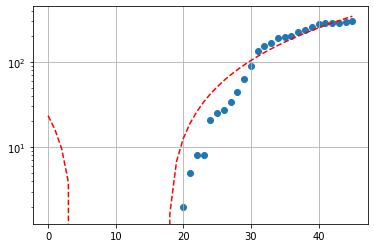

In [105]:
calculate_and_create_chart_for_province(START_DATE, 'Enna')

## Messina

Total cases per 1000 inhabitants up to today: 0.6267
Total cases up to today: 399
New cases registered today: 23
New cases registered today in %: 6.12
Doubling time in the last five days: 23.4
Doubling time yesterday: 31.6
Trend of new cases (in %) in the last 5 days: 15.99


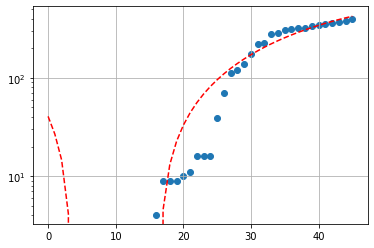

In [106]:
calculate_and_create_chart_for_province(START_DATE, 'Messina')

## Palermo

Total cases per 1000 inhabitants up to today: 0.2728
Total cases up to today: 346
New cases registered today: 17
New cases registered today in %: 5.17
Doubling time in the last five days: 22.2
Doubling time yesterday: 27.5
Trend of new cases (in %) in the last 5 days: 16.89


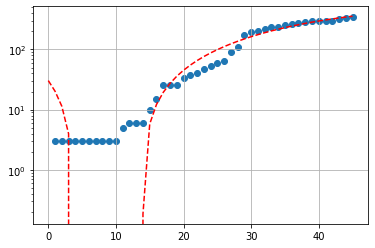

In [107]:
calculate_and_create_chart_for_province(START_DATE, 'Palermo')

## Ragusa

Total cases per 1000 inhabitants up to today: 0.1805
Total cases up to today: 58
New cases registered today: 2
New cases registered today in %: 3.57
Doubling time in the last five days: 16.5
Doubling time yesterday: 17.6
Trend of new cases (in %) in the last 5 days: 23.4


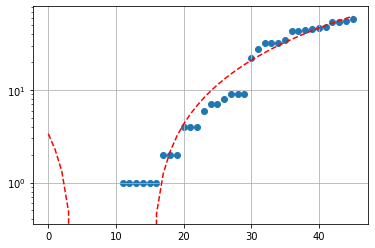

In [108]:
calculate_and_create_chart_for_province(START_DATE, 'Ragusa')

## Siracusa

Total cases per 1000 inhabitants up to today: 0.3078
Total cases up to today: 124
New cases registered today: 2
New cases registered today in %: 1.64
Doubling time in the last five days: 23.5
Doubling time yesterday: 24.7
Trend of new cases (in %) in the last 5 days: 15.89


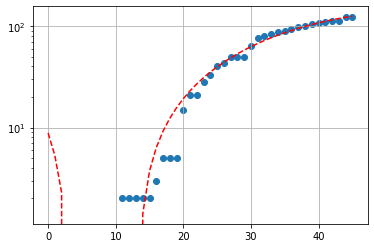

In [109]:
calculate_and_create_chart_for_province(START_DATE, 'Siracusa')

## Trapani

Total cases per 1000 inhabitants up to today: 0.267
Total cases up to today: 116
New cases registered today: 2
New cases registered today in %: 1.75
Doubling time in the last five days: 16.5
Doubling time yesterday: 10.1
Trend of new cases (in %) in the last 5 days: 23.4


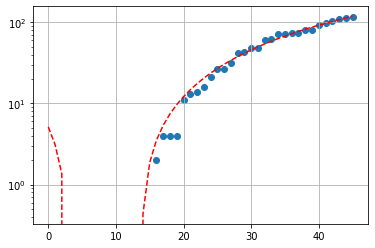

In [110]:
calculate_and_create_chart_for_province(START_DATE, 'Trapani')

# Casi di COVID-19 in Toscana - COVID-19 cases in Tuscany

Total cases up to today: 6552
New cases registered today: 173
New cases registered today in %: 2.71
Doubling time in the last five days: 24.0
Doubling time yesterday: 23.3
Trend of new cases (in %) in the last 5 days: 15.54


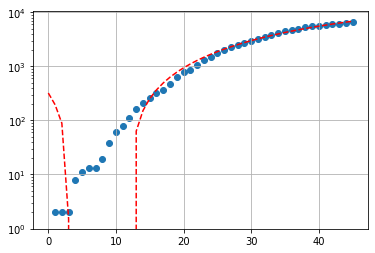

In [111]:
calculate_and_create_chart_for_region(START_DATE, 'Toscana')

## Arezzo

Total cases per 1000 inhabitants up to today: 1.1586
Total cases up to today: 399
New cases registered today: 1
New cases registered today in %: 0.25
Doubling time in the last five days: 45.9
Doubling time yesterday: 32.7
Trend of new cases (in %) in the last 5 days: 7.84


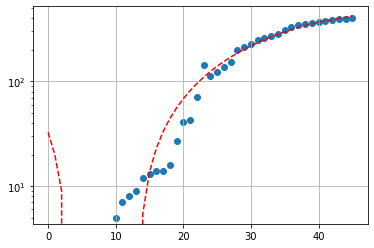

In [112]:
calculate_and_create_chart_for_province(START_DATE, 'Arezzo')

## Firenze

Total cases per 1000 inhabitants up to today: 1.9331
Total cases up to today: 1961
New cases registered today: 90
New cases registered today in %: 4.81
Doubling time in the last five days: 18.5
Doubling time yesterday: 18.0
Trend of new cases (in %) in the last 5 days: 20.6


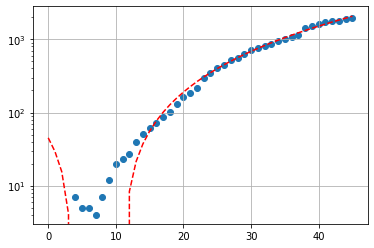

In [113]:
calculate_and_create_chart_for_province(START_DATE, 'Firenze')

## Grosseto

Total cases per 1000 inhabitants up to today: 1.3092
Total cases up to today: 292
New cases registered today: 2
New cases registered today in %: 0.69
Doubling time in the last five days: 51.5
Doubling time yesterday: 36.9
Trend of new cases (in %) in the last 5 days: 6.96


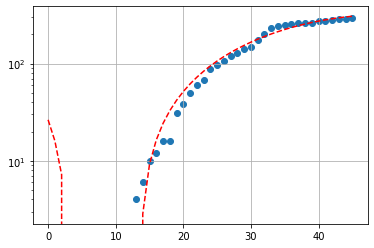

In [114]:
calculate_and_create_chart_for_province(START_DATE, 'Grosseto')

## Livorno

Total cases per 1000 inhabitants up to today: 1.0464
Total cases up to today: 353
New cases registered today: 4
New cases registered today in %: 1.15
Doubling time in the last five days: 31.3
Doubling time yesterday: 27.0
Trend of new cases (in %) in the last 5 days: 11.71


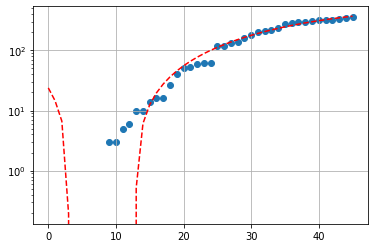

In [115]:
calculate_and_create_chart_for_province(START_DATE, 'Livorno')

## Lucca

Total cases per 1000 inhabitants up to today: 2.51
Total cases up to today: 979
New cases registered today: 25
New cases registered today in %: 2.62
Doubling time in the last five days: 25.6
Doubling time yesterday: 28.0
Trend of new cases (in %) in the last 5 days: 14.5


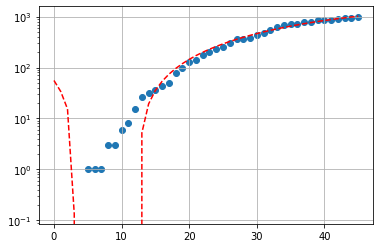

In [116]:
calculate_and_create_chart_for_province(START_DATE, 'Lucca')

## Massa Carrara

Total cases per 1000 inhabitants up to today: 4.0187
Total cases up to today: 790
New cases registered today: 21
New cases registered today in %: 2.73
Doubling time in the last five days: 19.1
Doubling time yesterday: 19.5
Trend of new cases (in %) in the last 5 days: 19.88


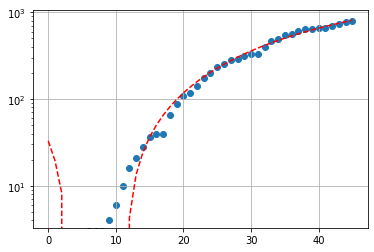

In [117]:
calculate_and_create_chart_for_province(START_DATE, 'Massa Carrara')

## Pisa

Total cases per 1000 inhabitants up to today: 1.4365
Total cases up to today: 606
New cases registered today: 14
New cases registered today in %: 2.36
Doubling time in the last five days: 24.8
Doubling time yesterday: 26.3
Trend of new cases (in %) in the last 5 days: 14.99


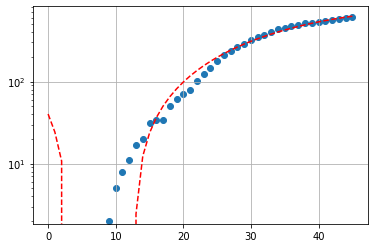

In [118]:
calculate_and_create_chart_for_province(START_DATE, 'Pisa')

## Pistoia

Total cases per 1000 inhabitants up to today: 1.5659
Total cases up to today: 457
New cases registered today: 7
New cases registered today in %: 1.56
Doubling time in the last five days: 17.3
Doubling time yesterday: 15.7
Trend of new cases (in %) in the last 5 days: 22.19


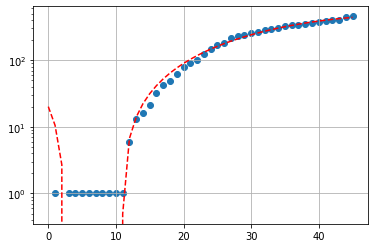

In [119]:
calculate_and_create_chart_for_province(START_DATE, 'Pistoia')

## Prato

Total cases per 1000 inhabitants up to today: 1.3943
Total cases up to today: 355
New cases registered today: 10
New cases registered today in %: 2.9
Doubling time in the last five days: 51.7
Doubling time yesterday: 52.6
Trend of new cases (in %) in the last 5 days: 6.93


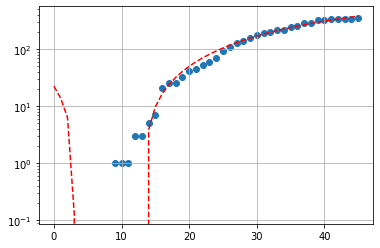

In [120]:
calculate_and_create_chart_for_province(START_DATE, 'Prato')

## Siena

Total cases per 1000 inhabitants up to today: 1.3416
Total cases up to today: 360
New cases registered today: -1
New cases registered today in %: -0.28
Doubling time in the last five days: 57.7
Doubling time yesterday: 50.4
Trend of new cases (in %) in the last 5 days: 6.19


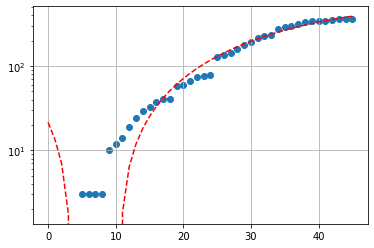

In [121]:
calculate_and_create_chart_for_province(START_DATE, 'Siena')

# Casi di COVID-19 in Provincia Autonoma di Trento - COVID-19 cases in the Autonomous Province of Trento

Total cases per 1000 inhabitants up to today: 5.0278
Total cases up to today: 2708
New cases registered today: 106
New cases registered today in %: 4.07
Doubling time in the last five days: 17.4
Doubling time yesterday: 16.5
Trend of new cases (in %) in the last 5 days: 21.98


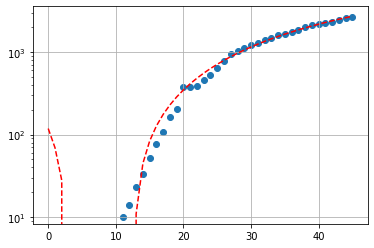

In [122]:
calculate_and_create_chart_for_province(START_DATE, 'Trento')

# Casi di COVID-19 in Umbria - COVID-19 cases in Umbria

Total cases up to today: 1252
New cases registered today: 8
New cases registered today in %: 0.64
Doubling time in the last five days: 49.9
Doubling time yesterday: 40.1
Trend of new cases (in %) in the last 5 days: 7.19


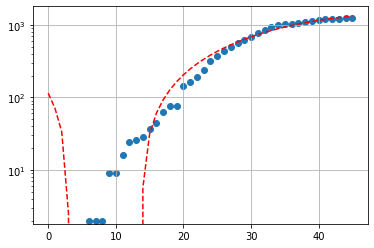

In [123]:
calculate_and_create_chart_for_region(START_DATE, 'Umbria')

## Perugia

Total cases per 1000 inhabitants up to today: 1.4333
Total cases up to today: 947
New cases registered today: 6
New cases registered today in %: 0.64
Doubling time in the last five days: 76.4
Doubling time yesterday: 55.5
Trend of new cases (in %) in the last 5 days: 4.64


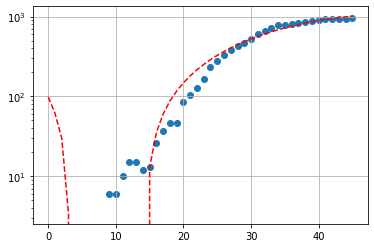

In [124]:
calculate_and_create_chart_for_province(START_DATE, 'Perugia')

## Terni

Total cases per 1000 inhabitants up to today: 1.3364
Total cases up to today: 305
New cases registered today: 2
New cases registered today in %: 0.66
Doubling time in the last five days: 23.4
Doubling time yesterday: 21.0
Trend of new cases (in %) in the last 5 days: 15.97


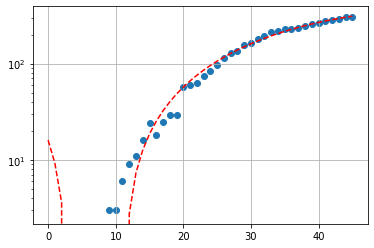

In [125]:
calculate_and_create_chart_for_province(START_DATE, 'Terni')

# Casi di COVID-19 in Valle d'Aosta - COVID-19 cases in Aosta Valley

Total cases per 1000 inhabitants up to today: 6.8409
Total cases up to today: 868
New cases registered today: 18
New cases registered today in %: 2.12
Doubling time in the last five days: 23.3
Doubling time yesterday: 20.7
Trend of new cases (in %) in the last 5 days: 16.04


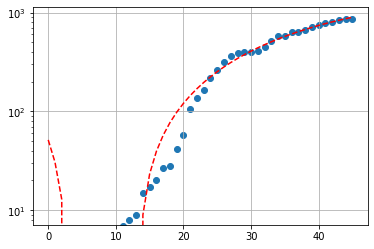

In [126]:
calculate_and_create_chart_for_province(START_DATE, "Aosta")

# Casi di COVID-19 in Veneto - COVID-19 cases in Veneto

Total cases up to today: 12594
New cases registered today: 509
New cases registered today in %: 4.21
Doubling time in the last five days: 19.5
Doubling time yesterday: 20.6
Trend of new cases (in %) in the last 5 days: 19.46


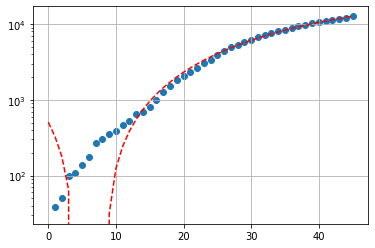

In [127]:
calculate_and_create_chart_for_region(START_DATE, 'Veneto')

## Belluno

Total cases per 1000 inhabitants up to today: 3.0129
Total cases up to today: 620
New cases registered today: 18
New cases registered today in %: 2.99
Doubling time in the last five days: 20.1
Doubling time yesterday: 18.5
Trend of new cases (in %) in the last 5 days: 18.77


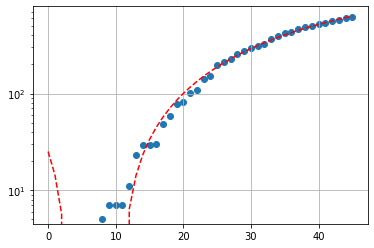

In [128]:
calculate_and_create_chart_for_province(START_DATE, 'Belluno')

## Padova

Total cases per 1000 inhabitants up to today: 3.3473
Total cases up to today: 3134
New cases registered today: 78
New cases registered today in %: 2.55
Doubling time in the last five days: 19.9
Doubling time yesterday: 19.3
Trend of new cases (in %) in the last 5 days: 19.07


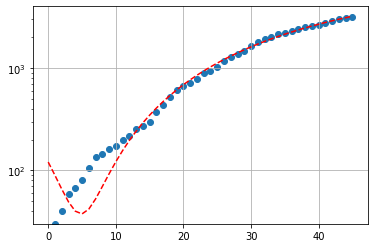

In [129]:
calculate_and_create_chart_for_province(START_DATE, 'Padova')

## Rovigo

Total cases per 1000 inhabitants up to today: 1.0436
Total cases up to today: 249
New cases registered today: 17
New cases registered today in %: 7.33
Doubling time in the last five days: 11.5
Doubling time yesterday: 13.7
Trend of new cases (in %) in the last 5 days: 35.33


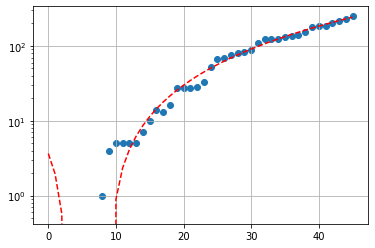

In [130]:
calculate_and_create_chart_for_province(START_DATE, 'Rovigo')

## Treviso

Total cases per 1000 inhabitants up to today: 2.1513
Total cases up to today: 1906
New cases registered today: 43
New cases registered today in %: 2.31
Doubling time in the last five days: 28.4
Doubling time yesterday: 29.6
Trend of new cases (in %) in the last 5 days: 12.98


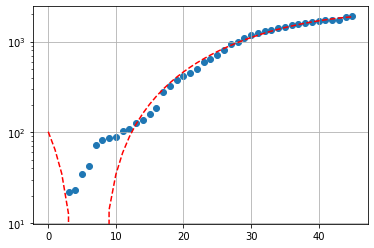

In [131]:
calculate_and_create_chart_for_province(START_DATE, 'Treviso')

## Venezia

Total cases per 1000 inhabitants up to today: 2.0497
Total cases up to today: 1751
New cases registered today: 121
New cases registered today in %: 7.42
Doubling time in the last five days: 13.8
Doubling time yesterday: 16.5
Trend of new cases (in %) in the last 5 days: 28.56


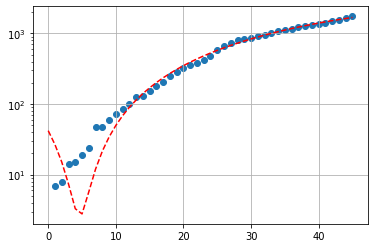

In [132]:
calculate_and_create_chart_for_province(START_DATE, 'Venezia')

## Verona

Total cases per 1000 inhabitants up to today: 3.3085
Total cases up to today: 3049
New cases registered today: 129
New cases registered today in %: 4.42
Doubling time in the last five days: 19.3
Doubling time yesterday: 21.6
Trend of new cases (in %) in the last 5 days: 19.71


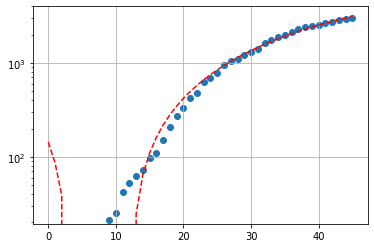

In [133]:
calculate_and_create_chart_for_province(START_DATE, 'Verona')

## Vicenza

Total cases per 1000 inhabitants up to today: 2.179
Total cases up to today: 1885
New cases registered today: 103
New cases registered today in %: 5.78
Doubling time in the last five days: 21.8
Doubling time yesterday: 21.3
Trend of new cases (in %) in the last 5 days: 17.23


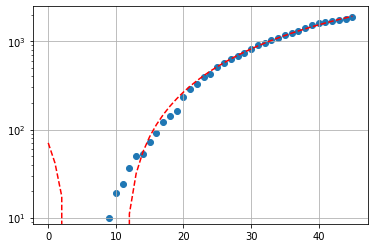

In [134]:
calculate_and_create_chart_for_province(START_DATE, 'Vicenza')